<a href="https://colab.research.google.com/github/daa103/DAA_ESAA/blob/main/%ED%95%AD%EA%B3%B5%ED%8E%B8%EC%98%88%EC%B8%A1_AI_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##항공편예측 AI

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train=pd.read_csv("/content/drive/MyDrive/ESAA_data/train.csv")
test=pd.read_csv("/content/drive/MyDrive/ESAA_data/test.csv")
submission=pd.read_csv("/content/drive/MyDrive/ESAA_data/sample_submission.csv")

###**EDA(데이터탐색)**
* ID : 샘플 고유 id
* 항공편 운항 관련 정보
* Month: 해당 항공편의 출발 월
* Day_of_Month: Month에 해당하는 월의 날짜
* Estimated_Departure_Time: 전산 시스템을 바탕으로 측정된 비행기의 출발 시간 (현지 시각, HH:MM 형식)
* Estimated_Arrival_Time: 전산 시스템을 바탕으로 측정된 비행기의 도착 시간 (현지 시각, HH:MM 형식)
* Cancelled: 해당 항공편의 취소 여부 (0: 취소되지 않음, 1: 취소됨)
* Diverted: 해당 항공편의 경유 여부 (0: 취소되지 않음, 1: 취소됨)
* Origin_Airport: 해당 항공편 출발 공항의 고유 코드 (IATA 공항 코드)
* Origin_Airport_ID: 해당 항공편 출발 공항의 고유 ID (US DOT ID)
* Origin_State: 해당 항공편 출발 공항이 위치한 주의 이름
* Destination_Airport: 해당 항공편 도착 공항의 고유 코드 (IATA 공항 코드)
* Destination_Airport_ID: 해당 항공편 도착 공항의 고유 ID (US DOT ID)
* Destination_State: 해당 항공편 도착 공항이 위치한 주의 이름
* Distance: 출발 공항과 도착 공항 사이의 거리 (mile 단위)
* Airline: 해당 항공편을 운항하는 항공사
* Carrier_Code(IATA): 해당 항공편을 운항하는 항공사의 고유 코드
(IATA 공항 코드, 단 다른 항공사가 같은 코드를 보유할 수도 있음)
* Carrier_ID(DOT): 해당 항공편을 운항하는 항공사의 고유 ID (US DOT ID)
* Tail_Number: 해당 항공편을 운항하는 항공기의 고유 등록번호
* Delay: 항공편 지연 여부 (Not_Delayed, Delayed)
예측해야 하는 타깃
>
다수의 데이터에 레이블이 존재하지 않음
>
준지도학습을 통해 레이블링 가능

**데이터구성**

In [4]:
train.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,NaN
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,NaN
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,NaN
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,NaN


In [5]:
test.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number
0,TEST_000000,12,16,1156.0,NaN,0,0,IAH,12266,Texas,SAT,14683,Texas,191.0,United Air Lines Inc.,UA,NaN,N79402
1,TEST_000001,9,12,1500.0,1715.0,0,0,EWR,11618,New Jersey,ATL,10397,NaN,746.0,Delta Air Lines Inc.,DL,19790.0,N3765
2,TEST_000002,3,6,1600.0,1915.0,0,0,ORD,13930,Illinois,LGA,12953,New York,733.0,United Air Lines Inc.,UA,19977.0,N413UA
3,TEST_000003,5,18,1920.0,2045.0,0,0,OAK,13796,California,LAX,12892,California,337.0,Southwest Airlines Co.,WN,19393.0,N905WN
4,TEST_000004,7,7,1915.0,2152.0,0,0,FLL,11697,Florida,LAX,12892,California,2343.0,JetBlue Airways,B6,20409.0,N945JT


In [6]:
submission.head()

,ID,Not_Delayed,Delayed
0,TEST_000000,0,1
1,TEST_000001,0,1
2,TEST_000002,0,1
3,TEST_000003,0,1
4,TEST_000004,0,1


In [7]:
print(train.shape)
print(test.shape)
print(submission.shape)

(1000000, 19)
(1000000, 18)
(1000000, 3)


**데이터요약**

In [8]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [9]:
pd.options.display.float_format = '{:.1f}'.format # 소숫점 자리수 출력값 format 설정

**요약통계량**

In [10]:
train.describe()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,1000000.0,1000000.0,890981.0,890960.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,891003.0
mean,6.9,15.8,1341.2,1493.3,0.0,0.0,12696.3,12701.8,784.1,19997.4
std,3.5,8.8,489.8,520.8,0.0,0.0,1514.9,1515.2,590.8,404.3
min,1.0,1.0,1.0,1.0,0.0,0.0,10135.0,10135.0,16.0,19393.0
25%,4.0,8.0,925.0,1105.0,0.0,0.0,11292.0,11292.0,350.0,19790.0
50%,7.0,16.0,1332.0,1524.0,0.0,0.0,12889.0,12889.0,623.0,19977.0
75%,10.0,23.0,1742.0,1924.0,0.0,0.0,14057.0,14057.0,1020.0,20378.0
max,12.0,31.0,2359.0,2400.0,0.0,0.0,16869.0,16869.0,5095.0,21171.0


In [11]:
test.describe()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,1000000.0,1000000.0,891016.0,890952.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,890994.0
mean,6.7,15.6,1377.1,1522.0,0.0,0.0,12688.0,12699.6,795.8,20001.3
std,3.5,8.7,487.6,528.3,0.0,0.0,1509.3,1512.9,594.6,402.9
min,1.0,1.0,1.0,1.0,0.0,0.0,10135.0,10135.0,16.0,19393.0
25%,3.0,8.0,954.8,1127.0,0.0,0.0,11292.0,11292.0,358.0,19790.0
50%,7.0,16.0,1405.0,1555.0,0.0,0.0,12889.0,12889.0,634.0,19977.0
75%,10.0,23.0,1800.0,1944.0,0.0,0.0,14027.0,14057.0,1034.0,20378.0
max,12.0,31.0,2400.0,2400.0,0.0,0.0,16869.0,16869.0,5095.0,21171.0


**결측치확인**

In [12]:
train.isna().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

In [13]:
test.isna().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    108984
Estimated_Arrival_Time      109048
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                106505
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           106523
Distance                         0
Airline                     106527
Carrier_Code(IATA)          108993
Carrier_ID(DOT)             109006
Tail_Number                      0
dtype: int64

결측값 존재 Column
* Estimated_Departure_Time: 전산 시스템을 바탕으로 측정된 비행기의 출발 시간
* Estimated_Arrival_Time: 전산 시스템을 바탕으로 측정된 비행기의 도착 시간
* Origin_State: 해당 항공편 출발 공항이 위치한 주의 이름
* Destination_State: 해당 항공편 도착 공항이 위치한 주의 이름
* Airline: 해당 항공편을 운항하는 항공사
* Carrier_Code(IATA): 해당 항공편을 운항하는 항공사의 고유 코드
* Carrier_ID(DOT): 해당 항공편을 운항하는 항공사의 고유 ID (US DOT ID)
* **Delay: 항공편 지연 여부 (Not_Delayed, Delayed) 예측해야 하는 타깃**

In [14]:
# ID, 취소항공편, 경유항공편, 항공사고유코드 칼럼 제거(항공사 고유 ID칼럼과 중복정보)
train= train.drop(columns=['ID','Cancelled','Diverted','Carrier_Code(IATA)'],axis=1)
test= test.drop(columns=['ID','Cancelled','Diverted','Carrier_Code(IATA)'],axis=1)

In [15]:
#Origin_Airport 와 Origin_Airport_ID 의 특성이 같아 하나를 드랍해줌
train = train.drop(['Origin_Airport'], axis = 1)
test = test.drop(['Origin_Airport'], axis = 1)

In [16]:
# Destination_Airport과 Destination_Airport_ID의 특성도 같아 하나를 드랍해줌
train = train.drop(['Destination_Airport'], axis = 1)
test = test.drop(['Destination_Airport'], axis = 1)

In [17]:
train.isna().sum()

Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

**월별 계절데이터 생성**


In [18]:
train['quart']=''
for i in range(len(train)):
  if train['Month'][i]>=1 and train['Month'][i]<=3:
    train['quart'][i]='1분기'
  elif train['Month'][i]>=4 and train['Month'][i]<=6:
    train['Month'][i]='2분기'
  elif train['Month'][i]>=7 and train['Month'][i]<=9 :
    train['quart'][i]='3분기'
  else:
    train['quart'][i]='4분기'

<ipython-input-18-daa4a4516150>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Month'][i]='2분기'
<ipython-input-18-daa4a4516150>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['quart'][i]='3분기'
<ipython-input-18-daa4a4516150>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['quart'][i]='1분기'
<ipython-input-18-daa4a4516150>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

**범주형 변수처리**

Delay만 변형-준지도학습후..?

- 실행안함

In [19]:
from sklearn.preprocessing import LabelEncoder

enc=LabelEncoder()

train['Delay']=enc.fit_transform(train['Delay'])

**결측치 제거하기**

In [20]:
# EDT와 EAT가 결측치를 가지면 Delay예측에 도움을 안줌
train = train.dropna(subset = ['Estimated_Departure_Time', 'Estimated_Departure_Time'], axis = 0)

In [21]:
# 결측값 존재 칼럼의 변수들을 최빈값으로 대체

Null_col=['Estimated_Departure_Time','Estimated_Arrival_Time','Origin_State','Destination_State','Airline','Carrier_ID(DOT)']

for col in Null_col:
  mode=train[col].mode()[0]
  train[col]=train[col].fillna(mode)

  if col in test.columns:
    test[col]=test[col].fillna(mode)

<ipython-input-21-9864e5dedefd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col]=train[col].fillna(mode)
<ipython-input-21-9864e5dedefd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col]=train[col].fillna(mode)


**주요 분포 파악**


In [22]:
train['Delay'].value_counts()

2    663821
1    187071
0     40089
Name: Delay, dtype: int64

In [23]:
train['Airline'].value_counts()[:5]

Southwest Airlines Co.    259251
Delta Air Lines Inc.       79936
SkyWest Airlines Inc.      77446
United Air Lines Inc.      74950
American Airlines Inc.     73786
Name: Airline, dtype: int64

**상관관계확인**

<ipython-input-24-2e1be1416b3f>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=train.corr()


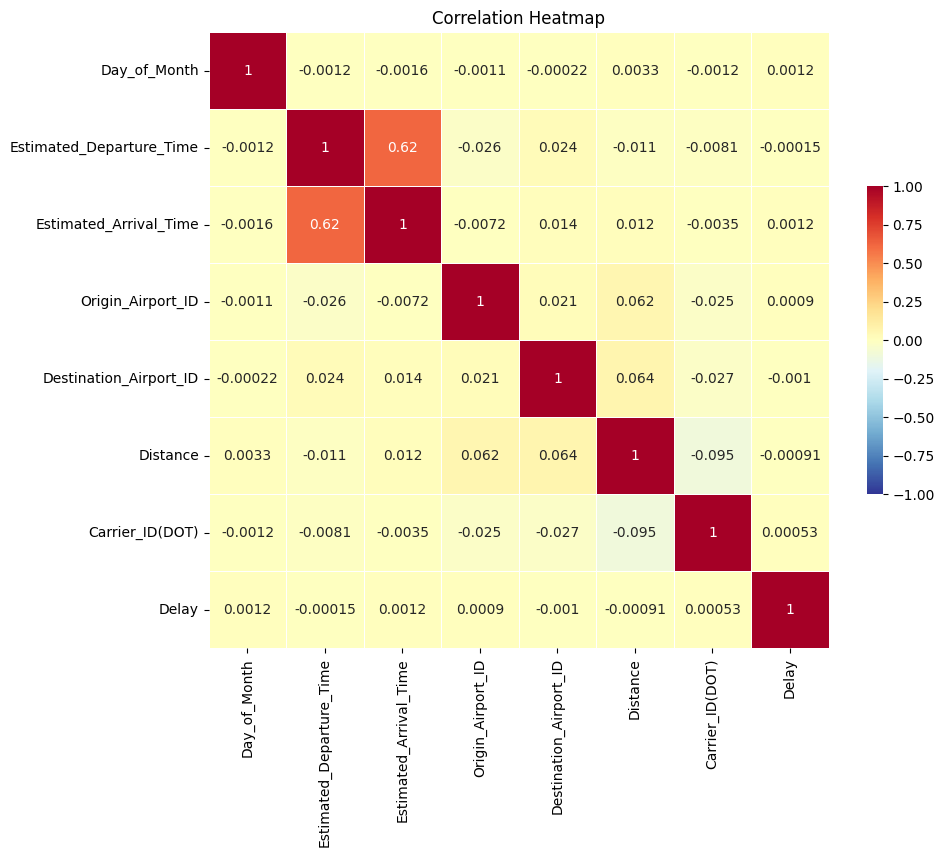

In [24]:
import seaborn as sns

plt.figure(figsize=(10,8))
corr=train.corr()
sns.heatmap(corr,
            cmap = 'RdYlBu_r',
            annot = True,   # 실제 값을 표시
            linewidths=.5,  # 경계면을 실선으로 구분하기
            cbar_kws={"shrink": .5}, # 컬러바 크기 절반으로 줄이기
            vmin = -1, vmax = 1   # 컬러바 범위: -1 ~ 1(상관계수의 범위)
           )

plt.title('Correlation Heatmap')
plt.show()